In [1]:
!pip install scanpy

     |████████████████████████████████| 2.0 MB 4.8 MB/s 
     |████████████████████████████████| 80 kB 6.9 MB/s 
     |████████████████████████████████| 127 kB 30.8 MB/s 
     |████████████████████████████████| 1.1 MB 25.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=56bbc0533bc3b2d86478c788a1f71bafdd07b6efedcdc8ea56ab406f776c4e5d
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=7c8f6ba62525120a8e78523077203550f450b2ceec1035f99d418fd50a082efd
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=8ccb236840707db83e16da2490ff96a865d83307f926d18a465f58aa1376e114
  Stored in directory: /root/.cache/

In [2]:
!pip install episcanpy

     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 185 kB 21.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.1 MB 31.3 MB/s 
     |████████████████████████████████| 9.9 MB 56.7 MB/s 
  Created wheel for episcanpy: filename=episcanpy-0.3.1-py3-none-any.whl size=111591 sha256=1dd98e2ca14bba5473d8603312cb03523a7f1d0388595658d684b2092bc2a9af
  Stored in directory: /root/.cache/pip/wheels/92/7a/6a/9b4b9c7e2a81047c870b1b19511bcacc825f520687fc907ef8
  Created wheel for bamnostic: filename=bamnostic-1.1.7-py3-none-any.whl size=178414 sha256=17978645271867c03f8e74a1725ae4dc88e0582f7eee804c2c69fedcc2d8748c
  Stored in directory: /root/.cache/pip/wheels/2b/40/51/aecf55becc5cba23cef969851d40e4738335d21bab7c2f730f
Successfully built episcanpy bamnostic


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install leidenalg

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 3.2 MB 29.6 MB/s 


In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import scipy
import anndata as ad
import episcanpy as epi

In [ ]:
##Baseline_Dataloader
raw_rna = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_rna_fragments.h5ad")
trans_rna_test = np.load("drive/MyDrive/output_0801_02/rna_trans_output_test.npy")
trans_rna_train = np.load("drive/MyDrive/output_0801_02/rna_trans_output_train.npy")
target_name_test = pd.read_table("drive/MyDrive/output_0801_02/rna_targets_test.txt", header=None)
target_name_train = pd.read_table("drive/MyDrive/output_0801_02/rna_targets_train.txt", header=None)

In [ ]:
def preprocessing_rna(
    adata,
    min_genes=200, 
    min_cells=0.01, 
    target_sum=1e4
):
    """
    preprocessing
    """
    print('Raw dataset for scRNA shape: {}'.format(adata.shape))
    if not issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)

    #Filtering cells
    #sc.pp.filter_cells(adata, min_genes=min_genes)

    #Flitering genes
    sc.pp.filter_genes(adata, min_cells=min_cells)

    #LogNormalize
    sc.pp.normalize_total(adata, target_sum=target_sum)
    sc.pp.log1p(adata)
    adata.raw = adata

    print('Processed dataset shape: {}'.format(adata.shape))
    return adata

In [ ]:
def Downstream_analysis(raw_data):
  adata = preprocessing_rna(raw_data)
  sc.pp.scale(adata, max_value=10)
  sc.tl.pca(adata, svd_solver='arpack')
  sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
  sc.tl.umap(adata)
  sc.tl.leiden(adata)
  sc.pl.umap(adata, color=['leiden']) #UMAP plot
  sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') #DE genes
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
  return adata

Raw dataset for scRNA shape: (4482, 32285)
Processed dataset shape: (4482, 24528)


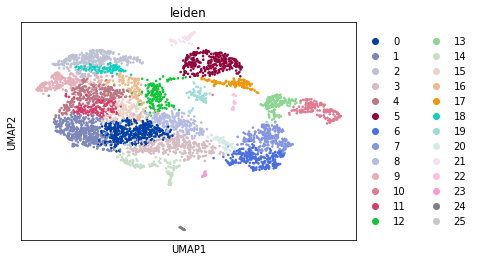

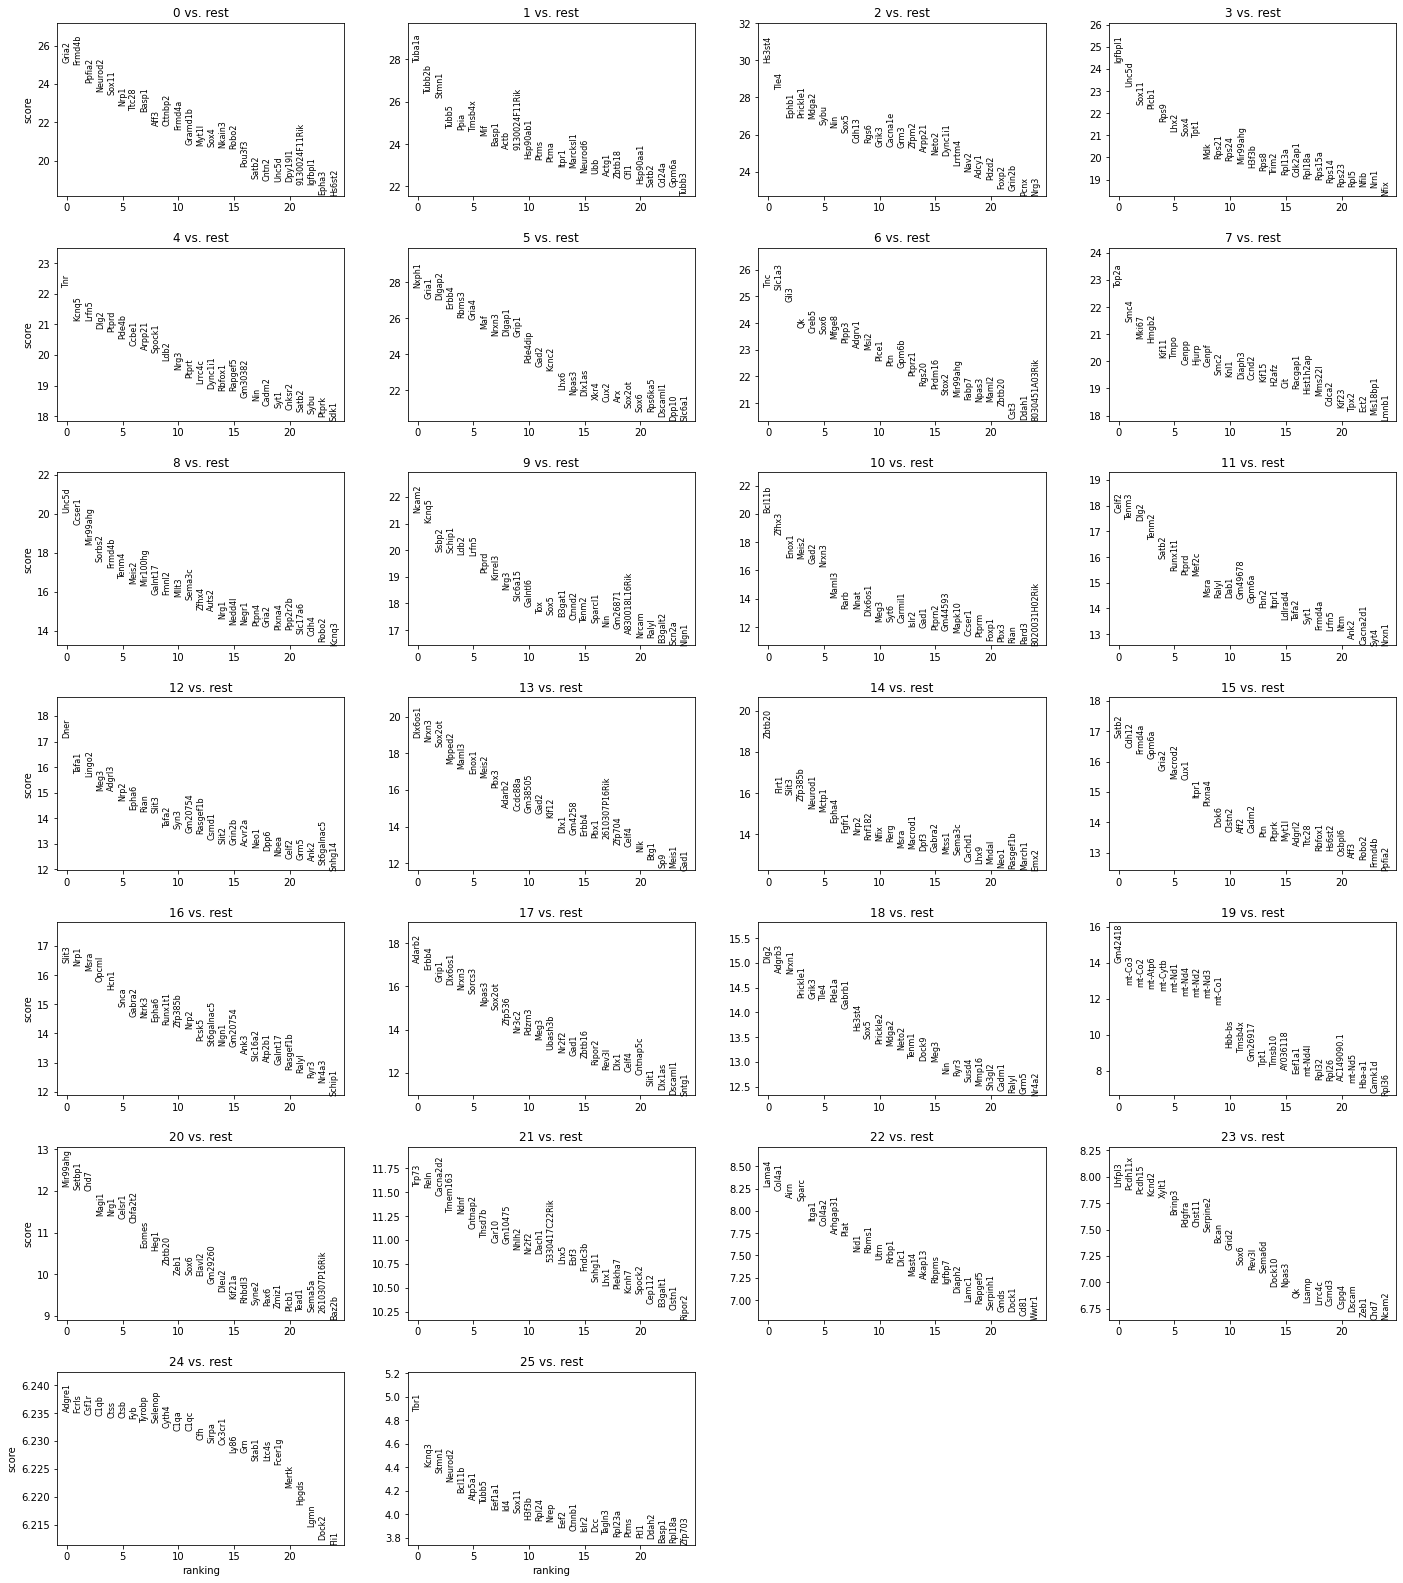

In [ ]:
raw_adata = Downstream_analysis(raw_rna)

In [ ]:
raw_adata_DE_genes = pd.DataFrame(raw_adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
def train_test_merge(train,test):
  pre_rna = preprocessing_rna(raw_rna)
  var_name = pre_rna.var_names
  cell_name_train = raw_rna.obs_names[:train.shape[0]]
  cell_name_test = raw_rna.obs_names[train.shape[0]:]
  train = pd.DataFrame(train, index = cell_name_train, columns=var_name)
  test = pd.DataFrame(test, index = cell_name_test, columns=var_name)
  trans_rna = train.append(test)
  adata = ad.AnnData(trans_rna, dtype = "int32")
  print(adata)
  return adata

In [ ]:
def train_test_merge_shuffle(train,test):
  pre_rna = preprocessing_rna(raw_rna)
  var_name = pre_rna.var_names
  cell_name_train = pd.Index(target_name_train)
  cell_name_test = pd.Index(target_name_test)
  train = pd.DataFrame(train, index = cell_name_train, columns=var_name)
  test = pd.DataFrame(test, index = cell_name_test, columns=var_name)
  trans_rna = train.append(test)
  adata = ad.AnnData(trans_rna, dtype = "int32")
  print(adata)
  return adata

In [ ]:
def Downstream_analysis_trans(train, test):
  adata = train_test_merge_shuffle(train, test)
  sc.pp.scale(adata, max_value=10)
  sc.tl.pca(adata, svd_solver='arpack')
  sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
  sc.tl.umap(adata)
  sc.tl.leiden(adata)
  sc.pl.umap(adata, color=['leiden']) #UMAP plot
  sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') #DE genes
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
  return adata

Raw dataset for scRNA shape: (4482, 32285)
Processed dataset shape: (4482, 24528)
AnnData object with n_obs × n_vars = 4482 × 24528


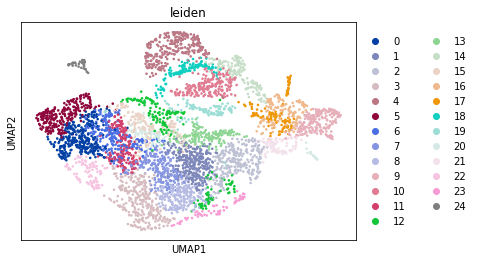

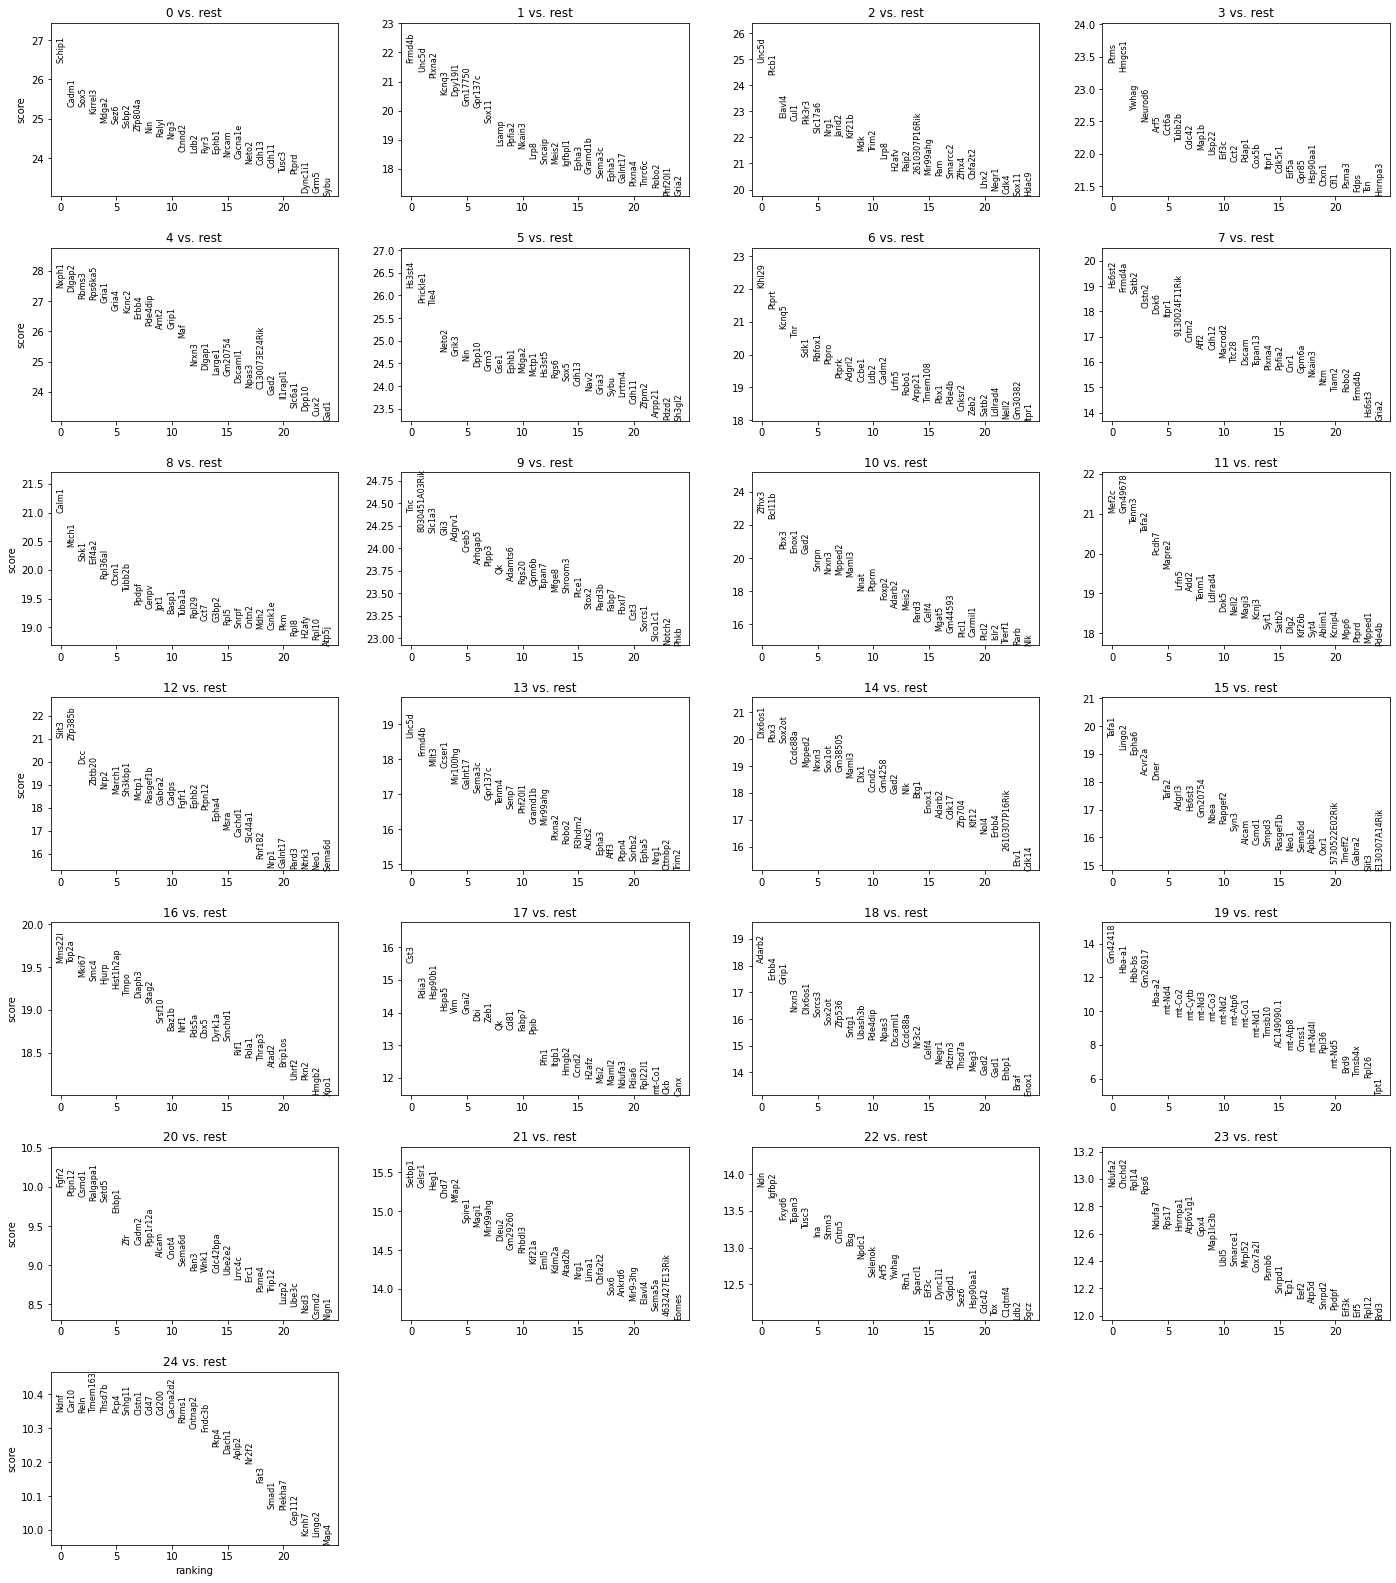

In [ ]:
predict_adata = Downstream_analysis_trans(trans_rna_train, trans_rna_test)

In [ ]:
predict_adata_DE_gene = pd.DataFrame(predict_adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
raw_adata_DE_genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Gria2,Tuba1a,Hs3st4,Igfbpl1,Tnr,Nxph1,Tnc,Top2a,Unc5d,Ncam2,Bcl11b,Celf2,Dner,Dlx6os1,Zbtb20,Satb2,Slit3,Adarb2,Dlg2,Gm42418,Mir99ahg,Trp73,Lama4,Lhfpl3,Adgre1,Tbr1
1,Frmd4b,Tubb2b,Tle4,Unc5d,Kcnq5,Gria1,Slc1a3,Smc4,Ccser1,Kcnq5,Zfhx3,Tenm3,Tafa1,Nrxn3,Flrt1,Cdh12,Nrp1,Erbb4,Adgrb3,mt-Co3,Setbp1,Reln,Col4a1,Pcdh11x,Fcrls,Kcnq3
2,Ppfia2,Stmn1,Ephb1,Sox11,Lrfn5,Dlgap2,Gli3,Mki67,Mir99ahg,Ssbp2,Enox1,Dlg2,Lingo2,Sox2ot,Slit3,Frmd4a,Msra,Grip1,Nrxn1,mt-Co2,Chd7,Cacna2d2,Airn,Pcdh15,Csf1r,Stmn1
3,Neurod2,Tubb5,Prickle1,Plcb1,Dlg2,Erbb4,Qk,Hmgb2,Sorbs2,Schip1,Meis2,Tenm2,Meg3,Mpped2,Zfp385b,Gpm6a,Opcml,Dlx6os1,Prickle1,mt-Atp6,Magi1,Tmem163,Sparc,Kcnd2,C1qb,Neurod2
4,Sox11,Ppia,Mdga2,Rps9,Ptprd,Rbms3,Creb5,Kif11,Frmd4b,Ldb2,Gad2,Satb2,Adgrl3,Maml3,Neurod1,Gria2,Hcn1,Nrxn3,Grik3,mt-Cytb,Nrg1,Ndnf,Itga1,Xylt1,Ctss,Bcl11b


In [ ]:
predict_adata_DE_gene

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,Schip1,Frmd4b,Unc5d,Ptms,Nxph1,Hs3st4,Klhl29,Hs6st2,Calm1,Tnc,Zfhx3,Mef2c,Slit3,Unc5d,Dlx6os1,Tafa1,Mms22l,Cst3,Adarb2,Gm42418,Fgfr2,Setbp1,Ndn,Ndufa2,Ndnf
1,Cadm1,Unc5d,Plcb1,Hmgcs1,Dlgap2,Prickle1,Ptprt,Frmd4a,Mtch1,8030451A03Rik,Bcl11b,Gm49678,Zfp385b,Frmd4b,Pbx3,Lingo2,Top2a,Pdia3,Erbb4,Hba-a1,Ptpn12,Celsr1,Igfbp2,Chchd2,Car10
2,Sox5,Plxna2,Elavl4,Ywhag,Rbms3,Tle4,Kcnq5,Satb2,Sbk1,Slc1a3,Pbx3,Tenm3,Dcc,Mllt3,Sox2ot,Epha6,Mki67,Hsp90b1,Grip1,Hbb-bs,Csmd1,Heg1,Fxyd6,Rpl14,Reln
3,Kirrel3,Kcnq3,Cul1,Neurod6,Rps6ka5,Neto2,Tnr,Clstn2,Eif4a2,Gli3,Enox1,Tafa2,Zbtb20,Ccser1,Ccdc88a,Acvr2a,Smc4,Hspa5,Nrxn3,Gm26917,Ralgapa1,Chd7,Tspan3,Rps6,Tmem163
4,Mdga2,Dpy19l1,Pik3r3,Arf5,Gria1,Grik3,Sdk1,Dok6,Rpl36al,Adgrv1,Gad2,Pcdh7,Nrp2,Mir100hg,Mpped2,Dner,Hjurp,Vim,Dlx6os1,Hba-a2,Setd5,Mfap2,Tusc3,Ndufa7,Thsd7b


Baseline(newdata):Frmd4b/Ppfia2, Sox11/Unc5d/Plcb1, Hs3st4/Tle4/Mdga2, Nxph1/Gria1/Dlgap2/Rbms3, Adarb2/Erbb4/Grip1/Dlx6osl,  Tnc/Slc1a3/Gli3, Ldb2/Kcnq5, Bcl11b/Zfhx3/Enox1/Gad2, Dner/Tafa1/Adgrl3, Dl6osl/Sox2ot/Mpped2/Maml3, Slit3/Zfp385b,  Trp73/Reln/Tmem163/Ndnf, Lhfpl3/Xylt1

Baseline(V2): Unc5d/Ccser1/Frmd4b, Hs3st4/Tle4/Ephb1/Prickle1, Unc5d/Sox11/Sema3c/Plcb1, Nxph1/Gria1/Dlgap2/Rbms3, Tnc/Gli3/Qk/Creb5, Kcnq5/Itpr1, Bcl11b/Zfhx3/Enox1/Gad2, Dner/Tafa1/Lingo2, Dlx6os1/Sox2ot/Mpped2/Maml3, Slit3/Nrp1/Hcn1/Opcml, Zfp385b/Slit3, Adarb2/Grip1, 

Same cell-type

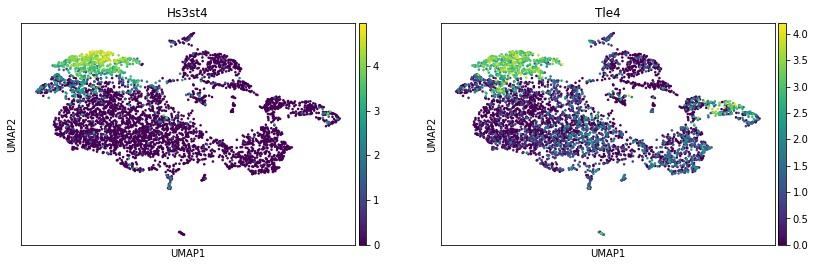

In [ ]:
sc.pl.umap(raw_adata, color=['Hs3st4','Tle4'])

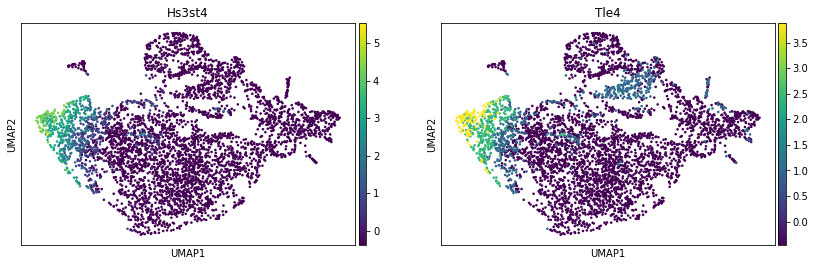

In [ ]:
sc.pl.umap(predict_adata, color=['Hs3st4','Tle4'])

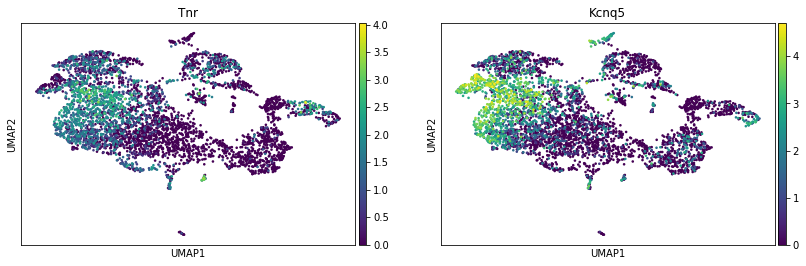

In [ ]:
sc.pl.umap(raw_adata, color=['Tnr','Kcnq5'])

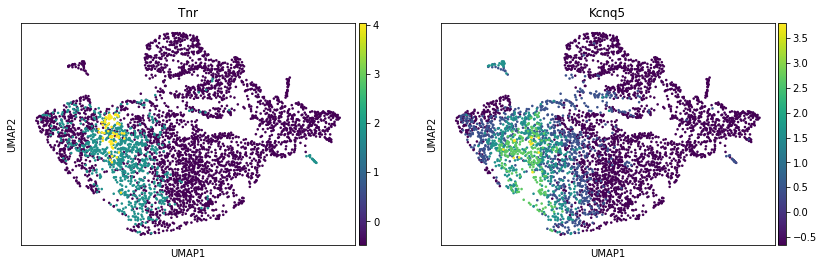

In [ ]:
sc.pl.umap(predict_adata, color=['Tnr','Kcnq5'])

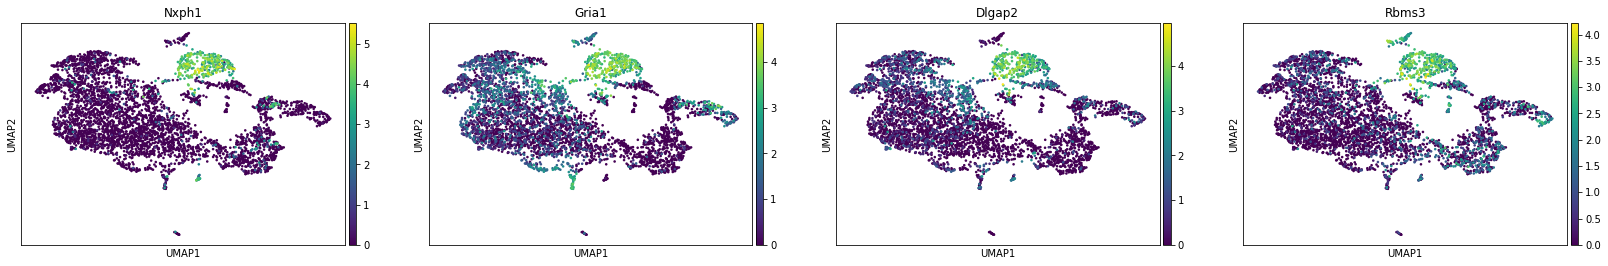

In [ ]:
sc.pl.umap(raw_adata, color=['Nxph1','Gria1','Dlgap2','Rbms3'])#Marker of neu cell-type

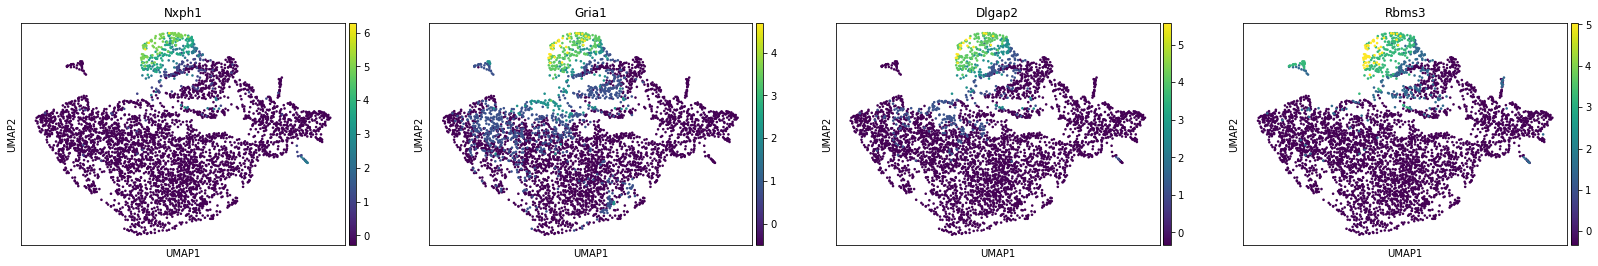

In [ ]:
sc.pl.umap(predict_adata, color=['Nxph1','Gria1','Dlgap2','Rbms3'])#Marker of neu cell-type

In [ ]:
neu_enrich_gene_trans = pd.DataFrame(predict_adata.uns['rank_genes_groups']['names'])['4']

In [ ]:
neu_enrich_gene_raw = pd.DataFrame(raw_adata.uns['rank_genes_groups']['names'])['5']

In [ ]:
neu_enrich_gene_raw.to_csv('neu_enrich_gene_raw.csv')
neu_enrich_gene_trans.to_csv('neu_enrich_gene_trans.csv')

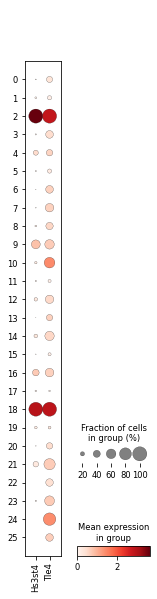

In [ ]:
sc.pl.dotplot(raw_adata,['Hs3st4','Tle4'], groupby='leiden')

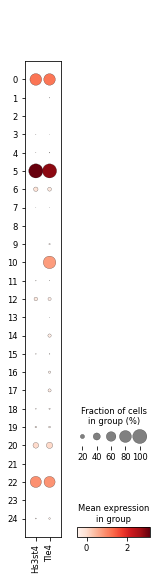

In [ ]:
sc.pl.dotplot(predict_adata, ['Hs3st4','Tle4'], groupby='leiden')

New insight


In [ ]:
raw_adata_DE_genes.to_csv('raw_adata_DE_genes.csv')

In [ ]:
predict_adata_DE_gene.to_csv('predict_adata_DE_genes.csv')

In [6]:
# mutul translation validation
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_atac_fragments.h5ad")

In [7]:
def preprocessing_atac(
        adata, 
        min_genes=200, 
        min_cells=0.01, 
        n_top_genes=30000,
        target_sum=None
    ):
    """
    preprocessing
    """
    print('Raw dataset for scATAC shape: {}'.format(adata.shape))

    if not issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)
    
    print(np.max(adata.X))    
    
    #binarize:
    #epi.pp.binarize(adata)
    
    #Filtering cells
    #sc.pp.filter_cells(adata, min_genes=min_genes)
    
    #'Filtering genes'
    if min_cells < 1:
        min_cells = min_cells * adata.shape[0]
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    #Finding variable features
    adata = epi.pp.select_var_feature(adata, nb_features=n_top_genes, show=False, copy=True)
    
    #Normalizing total per cell
    sc.pp.normalize_total(adata, target_sum=target_sum)
        

    print('Processed dataset shape: {}'.format(adata.shape))
    return adata

In [8]:
pre_atac = preprocessing_atac(raw_atac)

Raw dataset for scATAC shape: (4482, 172193)
239.0


Processed dataset shape: (4482, 30002)


In [9]:
df = pre_atac.to_df()

In [10]:
df

,chr1-3094582-3095477,chr1-3119674-3120516,chr1-3671318-3672224,chr1-4491535-4492451,chr1-4492877-4493786,chr1-4571380-4572305,chr1-4785278-4786187,chr1-4807391-4808286,chr1-5017834-5018686,chr1-5019135-5019979,chr1-5022592-5023449,chr1-5082785-5083721,chr1-5232504-5233394,chr1-5916814-5917674,chr1-6214341-6215189,chr1-6382539-6383412,chr1-6440937-6441856,chr1-6483195-6484130,chr1-6729251-6729986,chr1-9298603-9299204,chr1-9299340-9300084,chr1-9601000-9601912,chr1-9629800-9630714,chr1-9797844-9798781,chr1-9815491-9816395,chr1-9847835-9848779,chr1-10008706-10009618,chr1-10037593-10038494,chr1-10232576-10233375,chr1-10993271-10994132,chr1-11413773-11414685,chr1-12409881-12410790,chr1-12836529-12837266,chr1-12863807-12864709,chr1-12990121-12990725,chr1-12991990-12992900,chr1-13188105-13189026,chr1-13373629-13374558,chr1-13426084-13426959,chr1-13573697-13574611,...,chrX-163958225-163958955,chrX-164313620-164314535,chrX-164381595-164382483,chrX-164419218-164420111,chrX-164980058-164980950,chrX-166169991-166170874,chrX-166238667-166239472,chrX-166286533-166287487,chrX-166316571-166317458,chrX-166328722-166329642,chrX-166344227-166345159,chrX-166347651-166348466,chrX-166440258-166441170,chrX-166479286-166480163,chrX-166510000-166510874,chrX-166748873-166749776,chrX-167208739-167209648,chrX-167382297-167383032,chrX-168122859-168123778,chrX-168673336-168674098,chrX-169036249-169037146,chrX-169319930-169320840,chrX-169879236-169880070,chrX-169978859-169979779,chrX-170674311-170675224,chrX-170675860-170676661,chrX-170677220-170678084,chrY-90739919-90740754,chrY-90808426-90809305,chrY-90810454-90811323,GL456233.1-38762-39662,GL456233.1-110859-111723,JH584304.1-62098-62936,JH584304.1-67417-68381,JH584304.1-68672-69409,GL456216.1-13436-14345,GL456216.1-32372-33297,GL456216.1-34858-35723,GL456216.1-38444-39295,JH584295.1-1378-1976
AAACAGCCAACCGCCA-1,0.000000,0.000000,3.220298,0.805074,0.0,0.000000,0.805074,0.000000,0.0,0.0,0.000000,0.805074,1.610149,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.805074,0.0,0.0,4.830447,1.610149,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,4.025373,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.610149,0.000000,0.000000,0.000000,0.000000,0.000000
AAACAGCCAAGGTCGA-1,0.000000,0.000000,2.771444,0.000000,0.0,0.000000,5.542887,0.000000,0.0,0.0,1.385722,0.000000,0.000000,1.385722,0.000000,0.000000,2.771444,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.928609,2.771444,0.0,2.771444,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,2.771444,2.771444,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5.542887,0.0,2.771444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.771444,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACAGCCAGGAACAT-1,0.000000,1.078567,1.078567,0.000000,0.0,0.000000,0.000000,1.078567,0.0,0.0,1.078567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.078567,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.539284,1.078567,0.000000,0.000000,1.078567,...,0.000000,0.0,0.000000,0.539284,0.0,1.078567,0.0,0.000000,0.000000,0.000000,1.078567,0.0,0.000000,0.000000,0.000000,1.078567,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.539284,0.0,0.539284,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.157134,0.539284,0.000000,0.000000
AAACAGCCATATTGAC-1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.432291,0.000000,0.0,0.0,0.716146,1.432291,0.000000,0.000000,0.000000,2.148437,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000

In [14]:
df.loc[:, df.columns.str.startswith('chr1-134')]

,chr1-13426084-13426959,chr1-134024275-134025160,chr1-134026481-134027380,chr1-134045747-134046618,chr1-134048490-134049382,chr1-134060627-134061532,chr1-134063014-134063755,chr1-134071319-134072160,chr1-134077190-134078016,chr1-134092725-134093600,chr1-134096023-134096927,chr1-134098877-134099800,chr1-134119955-134120845,chr1-134151425-134152329,chr1-134203969-134204850,chr1-134243926-134244839,chr1-134246377-134247273,chr1-134298728-134299640,chr1-134335399-134336327,chr1-134344310-134345193,chr1-134405552-134406421,chr1-134455034-134455954,chr1-134518366-134519261,chr1-134556596-134557347,chr1-134560007-134560524,chr1-134560632-134561237,chr1-134646132-134647039,chr1-134708673-134709547,chr1-134854045-134854944,chr1-134987333-134988224
AAACAGCCAACCGCCA-1,0.000000,1.610149,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.025373,0.000000,1.610149,0.000000,0.0,0.000000,0.0,0.000000,0.000000,3.220298,1.610149,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.610149,0.000000,0.0
AAACAGCCAAGGTCGA-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.771444,0.000000,0.000000,1.385722,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.771444,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
AAACAGCCAGGAACAT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.078567,1.078567,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.157134,0.539284,0.000000,1.078567,0.0,1.078567,0.0,0.000000,0.0,0.539284,0.539284,0.0
AAACAGCCATATTGAC-1,0.000000,0.000000,1.432291,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.432291,0.000000,1.432291,2.864582,0.000000,0.0,1.432291,0.0,0.000000,1.432291,2.864582,0.000000,1.432291,0.0,0.000000,0.0,0.000000,0.0,2.148437,0.000000,0.0
AAACAGCCATCAGCAC-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.349376,0.0,0.000000,0.0,0.000000,0.0,1.349376,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATTTGCTC-1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.334802,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
TTTGTGTTCAATGACC-1,0.378662,0.000000,0.000000,0.0,0.000000,1.514649,1.514649,0.0,0.000000,1.514649,0.757325,0.000000,0.757325,0.000000,0.0,0.000000,0.0,0.757325,0.000000,0.757325,0.000000,0.757325,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
TTTGTTGGTAGACAAA-1,2.466691,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.822230,0.0,0.000000,0.0,0.000000,0.000000,0.0
TTTGTTGGTGGAGCAA-1,0.000000,0.000000,0.000000,0.0,3.107918,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [15]:
np.sum(df.loc[:, df.columns.str.startswith('chr1-134')])

chr1-13426084-13426959      1117.849365
chr1-134024275-134025160     794.062134
chr1-134026481-134027380     723.768372
chr1-134045747-134046618    1309.142334
chr1-134048490-134049382     976.152405
chr1-134060627-134061532    2261.899902
chr1-134063014-134063755    1802.666870
chr1-134071319-134072160     487.813995
chr1-134077190-134078016     669.189087
chr1-134092725-134093600    2468.121338
chr1-134096023-134096927    1595.191895
chr1-134098877-134099800    1012.558411
chr1-134119955-134120845    1002.251221
chr1-134151425-134152329     739.851624
chr1-134203969-134204850     524.541748
chr1-134243926-134244839     805.909424
chr1-134246377-134247273     517.652893
chr1-134298728-134299640     670.476685
chr1-134335399-134336327     503.116425
chr1-134344310-134345193    2810.599365
chr1-134405552-134406421    1660.823486
chr1-134455034-134455954    3061.463867
chr1-134518366-134519261     854.013794
chr1-134556596-134557347    3271.824219
chr1-134560007-134560524     833.090210


In [ ]:
peek_Hs3st4 = df.loc[:, df.columns.str.startswith('chr7-1235')]

In [ ]:
# cell population
leiden_group = raw_adata.obs['leiden']
leiden_group = leiden_group.to_frame()
leiden_cell_name = leiden_group.loc[leiden_group['leiden']=='2'].index

In [ ]:
for i in range(0,26):
  leiden_cell_name = leiden_group.loc[leiden_group['leiden']==str(i)].index
  data = pd.DataFrame(peek_Hs3st4.loc[leiden_cell_name[0]]).T
  for j in range(1,leiden_cell_name.shape[0]):
    cell = pd.DataFrame(peek_Hs3st4.loc[leiden_cell_name[j]]).T
    data = data.append(cell)
  print('leiden group: {}'.format(i),np.sum(data)/np.sum(peek_Hs3st4))

leiden group: 0 chr7-123523984-123524875    0.097208
dtype: float32
leiden group: 1 chr7-123523984-123524875    0.124838
dtype: float32
leiden group: 2 chr7-123523984-123524875    0.080302
dtype: float32
leiden group: 3 chr7-123523984-123524875    0.056742
dtype: float32
leiden group: 4 chr7-123523984-123524875    0.089597
dtype: float32
leiden group: 5 chr7-123523984-123524875    0.124277
dtype: float32
leiden group: 6 chr7-123523984-123524875    0.026267
dtype: float32
leiden group: 7 chr7-123523984-123524875    0.031524
dtype: float32
leiden group: 8 chr7-123523984-123524875    0.026393
dtype: float32
leiden group: 9 chr7-123523984-123524875    0.054854
dtype: float32
leiden group: 10 chr7-123523984-123524875    0.037056
dtype: float32
leiden group: 11 chr7-123523984-123524875    0.012728
dtype: float32
leiden group: 12 chr7-123523984-123524875    0.042852
dtype: float32
leiden group: 13 chr7-123523984-123524875    0.004782
dtype: float32
leiden group: 14 chr7-123523984-123524875   

In [ ]:
df.loc[:, df.columns.str.startswith('chr19-14')]

,chr19-14225101-14226005,chr19-14240555-14241500,chr19-14300948-14301815,chr19-14435585-14436493,chr19-14680992-14681885,chr19-14777073-14777977,chr19-14883755-14884668,chr19-14890438-14891266,chr19-14957237-14958168
AAACAGCCAACCGCCA-1,0.0,0.000000,1.610149,0.000000,0.000000,1.610149,0.000000,0.000000,0.0
AAACAGCCAAGGTCGA-1,0.0,0.000000,0.000000,0.000000,0.000000,2.771444,0.000000,0.000000,0.0
AAACAGCCAGGAACAT-1,0.0,0.000000,0.000000,0.000000,1.617851,0.000000,0.000000,1.078567,0.0
AAACAGCCATATTGAC-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
AAACAGCCATCAGCAC-1,0.0,1.349376,0.000000,1.349376,0.000000,2.698752,0.674688,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
TTTGTGGCATTTGCTC-1,0.0,0.000000,0.000000,0.000000,0.000000,3.334802,0.000000,0.000000,0.0
TTTGTGTTCAATGACC-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
TTTGTTGGTAGACAAA-1,0.0,0.822230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
TTTGTTGGTGGAGCAA-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
peak_Tle4 = df.loc[:, df.columns.str.startswith('chr19-144')]

In [ ]:
for i in range(0,26):
  leiden_cell_name = leiden_group.loc[leiden_group['leiden']==str(i)].index
  data = pd.DataFrame(peak_Tle4.loc[leiden_cell_name[0]]).T
  for j in range(1,leiden_cell_name.shape[0]):
    cell = pd.DataFrame(peak_Tle4.loc[leiden_cell_name[j]]).T
    data = data.append(cell)
  print('leiden group: {}'.format(i),np.sum(data)/np.sum(peak_Tle4))

leiden group: 0 chr19-14435585-14436493    0.131773
dtype: float32
leiden group: 1 chr19-14435585-14436493    0.04515
dtype: float32
leiden group: 2 chr19-14435585-14436493    0.110126
dtype: float32
leiden group: 3 chr19-14435585-14436493    0.149108
dtype: float32
leiden group: 4 chr19-14435585-14436493    0.080881
dtype: float32
leiden group: 5 chr19-14435585-14436493    0.010143
dtype: float32
leiden group: 6 chr19-14435585-14436493    0.067636
dtype: float32
leiden group: 7 chr19-14435585-14436493    0.086198
dtype: float32
leiden group: 8 chr19-14435585-14436493    0.084604
dtype: float32
leiden group: 9 chr19-14435585-14436493    0.039869
dtype: float32
leiden group: 10 chr19-14435585-14436493    0.000772
dtype: float32
leiden group: 11 chr19-14435585-14436493    0.006238
dtype: float32
leiden group: 12 chr19-14435585-14436493    0.016818
dtype: float32
leiden group: 13 chr19-14435585-14436493    0.001677
dtype: float32
leiden group: 14 chr19-14435585-14436493    0.012395
dtype: